# Analyse du fichier `clean_monthly_modal`

Ce notebook contient une analyse structurée du fichier transport nettoyé.

In [7]:
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath("../.."))  # monte 2 niveaux pour accéder à `utils/`

from utils.db_utils import connect_db

# Connexion à la base
engine = connect_db()

# Récupérer les données clean
df = pd.read_sql("SELECT * FROM clean_monthly_modal", engine)

# Aperçu
df.head(3)


,ntd_id,agency,organization_type,mode,type_of_service,rail_true_false,primary_uza_uace_code,primary_uza_name,year,month,...,pedestrian_not_in_crosswalk_injuries,pedestrian_crossing_tracks_injuries,pedestrian_walking_along_tracks_injuries,other_vehicle_occupant_injuries,other_injuries,trespasser_injuries,suicide_injuries,total_other_injuries,total_injuries,moyr
0,20008,MTA NEW YORK CITY TRANSIT,"UNIT OF A TRANSIT AGENCY, REPORTING SEPARATELY",HR,DO,True,63217.0,"NEW YORK--JERSEY CITY--NEWARK, NY--NJ",2014,JANUARY,...,0.0,0.0,0.0,0.0,17.0,0.0,2.0,19.0,301.0,20140101
1,20008,MTA NEW YORK CITY TRANSIT,"UNIT OF A TRANSIT AGENCY, REPORTING SEPARATELY",HR,DO,True,63217.0,"NEW YORK--JERSEY CITY--NEWARK, NY--NJ",2014,FEBRUARY,...,0.0,2.0,0.0,0.0,20.0,0.0,3.0,25.0,235.0,20140201
2,20008,MTA NEW YORK CITY TRANSIT,"UNIT OF A TRANSIT AGENCY, REPORTING SEPARATELY",HR,DO,True,63217.0,"NEW YORK--JERSEY CITY--NEWARK, NY--NJ",2014,MARCH,...,0.0,0.0,0.0,0.0,19.0,0.0,3.0,22.0,246.0,20140301


##  Analyse temporelle des passagers

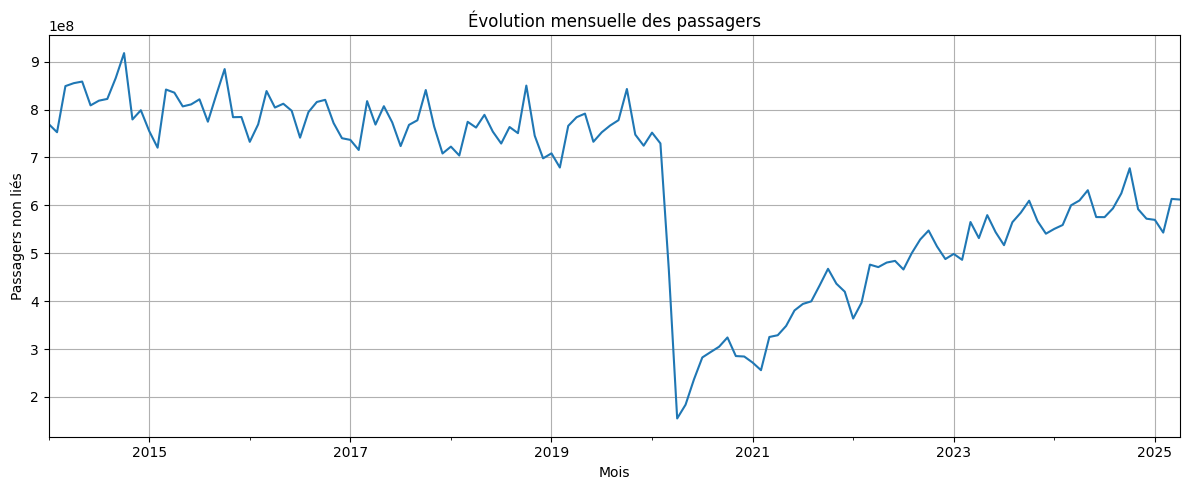

In [8]:
if "moyr" in df.columns:
    df["date"] = pd.to_datetime(df["moyr"].astype(str), format="%Y%m%d", errors="coerce")
monthly_passengers = df.groupby(df['date'].dt.to_period('M'))['unlinked_passenger_trips'].sum()

plt.figure(figsize=(12, 5))
monthly_passengers.plot()
plt.title("Évolution mensuelle des passagers")
plt.xlabel("Mois")
plt.ylabel("Passagers non liés")
plt.grid(True)
plt.tight_layout()
plt.show()

##  Productivité des véhicules (heures / véhicules)

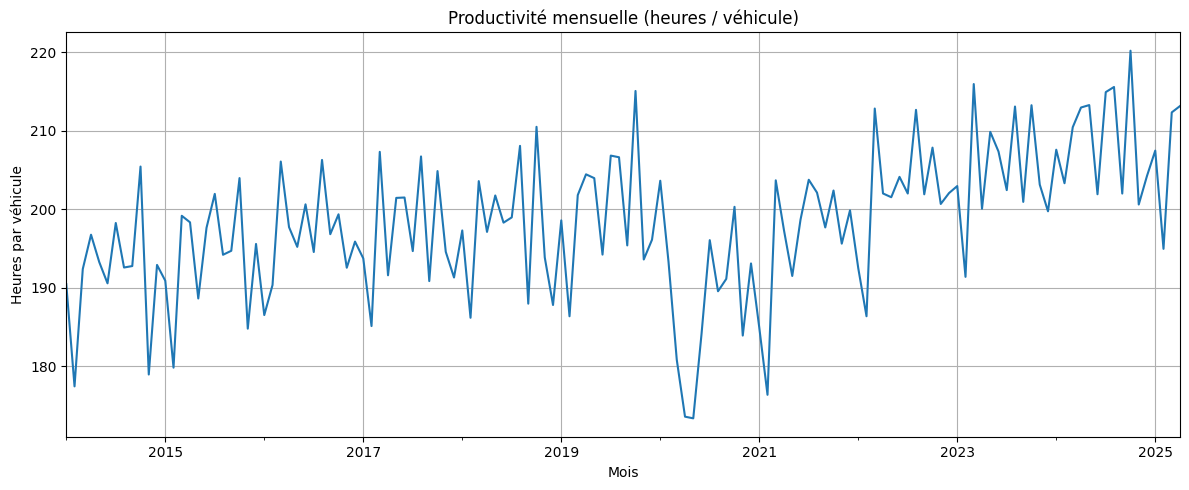

In [9]:
df_productivity = df[df["voms"] > 0].copy()
df_productivity["productivity"] = df_productivity["vehicle_revenue_hours"] / df_productivity["voms"]
productivity_trend = df_productivity.groupby(df_productivity["date"].dt.to_period("M"))["productivity"].mean()

plt.figure(figsize=(12, 5))
productivity_trend.plot()
plt.title("Productivité mensuelle (heures / véhicule)")
plt.xlabel("Mois")
plt.ylabel("Heures par véhicule")
plt.grid(True)
plt.tight_layout()
plt.show()

##  Taux d’incidents pour 1 million de km

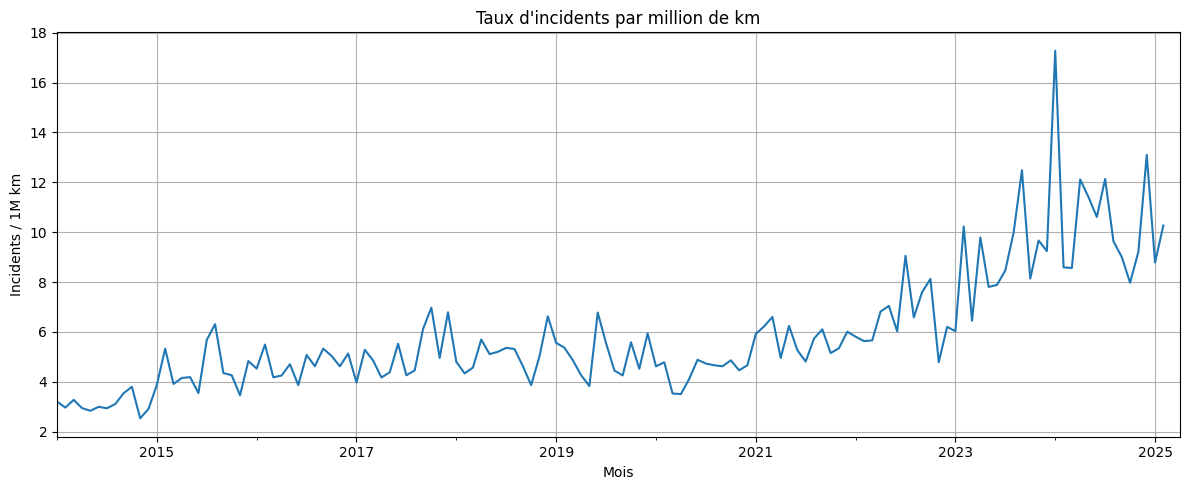

In [10]:
df_incidents = df[df["vehicle_revenue_miles"] > 0].copy()
df_incidents["incidents_per_million_km"] = df_incidents["total_events"] / df_incidents["vehicle_revenue_miles"] * 1_000_000
incident_trend = df_incidents.groupby(df_incidents["date"].dt.to_period("M"))["incidents_per_million_km"].mean()

plt.figure(figsize=(12, 5))
incident_trend.plot()
plt.title("Taux d'incidents par million de km")
plt.xlabel("Mois")
plt.ylabel("Incidents / 1M km")
plt.grid(True)
plt.tight_layout()
plt.show()

##  Répartition par mode de transport

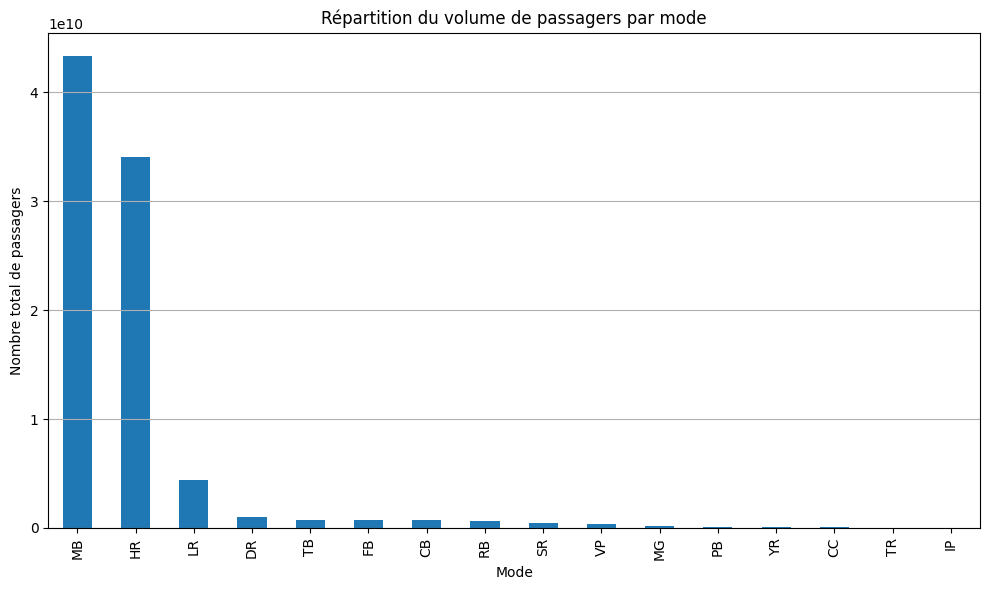

In [11]:
mode_activity = df.groupby("mode")["unlinked_passenger_trips"].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
mode_activity.plot(kind="bar")
plt.title("Répartition du volume de passagers par mode")
plt.xlabel("Mode")
plt.ylabel("Nombre total de passagers")
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()